In [1]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# load the mnist dataset
# https://www.geeksforgeeks.org/python-os-path-join-method/
# https://stackoverflow.com/questions/37400974/unicode-error-unicodeescape-codec-cant-decode-bytes-in-position-2-3-trunca
# 
# note to self: 1) read error message, 2) follow some tutorial or improvise, 3) official docs


def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join(r"\Users\tyjin\OneDrive\Documents\Deep learning", hashlib.md5(url.encode('utf-8')).hexdigest())
  print(fp)
  if os.path.isfile(fp):
    
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

\Users\tyjin\OneDrive\Documents\Deep learning\23278f029ff68f1e993776e500ce06b9
\Users\tyjin\OneDrive\Documents\Deep learning\d8b415e67abd11881e156b8f111d3300
\Users\tyjin\OneDrive\Documents\Deep learning\b0cdab8e37ae7c1c5560ee858afaac1d
\Users\tyjin\OneDrive\Documents\Deep learning\d4fdde61aca9f72d5fe2315410bb46a5


In [3]:
# testing os.path.join for understanding.
import os
# Path
path = r"\Users\tyjin\OneDrive\Documents"
 
# Join various path components
print(os.path.join(path, "User\Desktop", "file.txt"))

\Users\tyjin\OneDrive\Documents\User\Desktop\file.txt


(<matplotlib.image.AxesImage at 0x2a92956ad60>, 4)

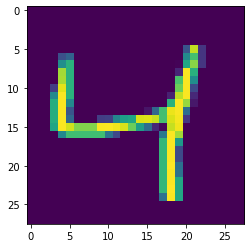

In [4]:
# check imported data to see if they are correctly imported and matched.
imshow(X_train[2]), Y_train[2]

In [1]:
# model

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
   
    self.l2 = nn.Linear(128, 10, bias=False)
    #self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    
    x = self.l2(x)
    #x = self.sm(x)
    return x

model = BobNet()

In [ ]:
?reshape

In [69]:
print(X_train[0:10].shape)
print(X_train[0:10].reshape((-1,28*28)).shape)

(10, 28, 28)
(10, 784)


In [49]:
# validating what usage torch.argmax does in [47]

out = model(torch.tensor(X_train[0:10].reshape((-1,28*28))).float())

Y = torch.tensor(Y_train[0:10]).long()
print(Y)
# torch.argmax returns the indices of the maximum value of all elements in the input tensor.
cat = torch.argmax(out, dim=1)
print(cat)
accuracy = (cat == Y)
print(accuracy)
# need to change values from boolean to numeric in order to calculate mean
print(accuracy.float().mean())


tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])
tensor([True, True, True, True, True, True, True, True, True, True])
tensor(1.)


In [97]:
"""
first iteration of hotz's generic backprop
"""

#5:45
#9:54 what is trange? and read up torch.optim(9:00++)
BS = 32
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
for i in range(2):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape((-1,28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    print(Y)
    optim.zero_grad()
    out = model(X)
    loss = loss_function(out, Y)
    loss.backward()
    optim.step()
    print(loss)

# remember model needs tensor as input and copy numpy data (see fetch function)
# so to protect data in original file from being overwritten

# 5:06 expected object of scalar type byte but got scalar type float
# https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ
# check if model works before getting loss by batch-size 32 above
# model(torch.tensor(X_train[0:10].reshape((-1,28*28))).float())

tensor([2, 4, 3, 2, 8, 2, 8, 7, 9, 7, 0, 6, 9, 3, 2, 9, 2, 4, 3, 2, 3, 8, 0, 4,
        0, 4, 0, 8, 3, 2, 4, 9])
tensor(0.2557, grad_fn=<NllLossBackward0>)
tensor([9, 8, 8, 4, 9, 5, 0, 3, 6, 2, 1, 8, 7, 9, 2, 4, 8, 0, 1, 1, 6, 2, 2, 0,
        2, 8, 2, 9, 8, 4, 6, 9])
tensor(0.3996, grad_fn=<NllLossBackward0>)


loss 0.22 accuracy 0.92: 100%|████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 309.02it/s]


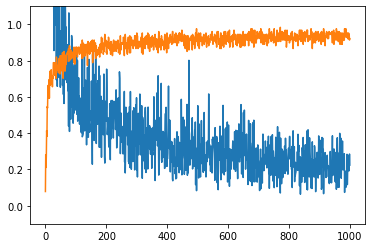

In [232]:
# training
# model has to be reinitialized again if params change because existing params
# fit previous params ? eg lr=0.01 vs lr=0.001, accuracy cannot be recovered maybe becuz
# existing params produce such bad results failing rate compared to A- of 0.001
# can think of that as going on a tangent path.
model = BobNet()
BS = 128
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001)
losses, accuracies = [], []

# iterates through 1000 sets of batch size 32, loss.backward calculate gradient and
# optim.step() updates parameters of NN for each nodes at each set, before iterating again
# and taking into consideration only the gradient at that set to revise param
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape((-1,28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    optim.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out,Y)
    # backward computes gradient
    loss.backward()
    # gradient descent: update params
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % 
                      (loss, accuracy))
    
plt.ylim(-0.1,1.1)
plot(losses)
plot(accuracies)

In [193]:
# put in .numpy so not testing (evaluating) in torch ? Ans: because original Y_test is npy array
# type(Y_test)
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1,28*28))).float()), dim=1).numpy()

In [194]:
# check predicted Y test values
(Y_test == Y_test_preds).mean()

0.9219

In [222]:
# init network

l1 = np.zeros((784,128), dtype=np.float32)
l2 = np.zeros((128,10),dtype=np.float32)
l1.dtype, l2.dtype
# googled "get object memory address"
id(l1),id(l2)

(2925964134800, 2925829591088)

In [224]:
# copy weights from previous pytorch model into the above initialized arrays
l1[:] = model.l1.weight.detach().numpy().transpose()
l2[:] = model.l2.weight.detach().numpy().transpose()
id(l1)


2925964134800

In [228]:
# numpy forward pass
# use np.maximum not np.max for ReLU
def forward(x):
    x = x.dot(l1)
    x = np.maximum(0,x)
    x = x.dot(l2)
    return x

In [234]:
Y_test_preds_out = forward(X_test.reshape((-1,28*28)))
Y_test_preds = np.argmax(Y_test_preds_out,axis=1)
(Y_test == Y_test_preds).mean()

0.9219

In [ ]:
# training in numpy
# check out torch.nn.Module, contains F.relu; upgrade BobNet with F.relu

In [294]:
#37.00: figuring out derivatives; looked at crossentropyloss doc, log of exp sum
Y_test_preds_out[1]

array([  7.1152096,   1.5035615,  25.269108 ,   2.144893 ,  -7.9498167,
         6.228894 ,  16.03733  ,  -5.542251 ,   3.3134136, -16.48542  ],
      dtype=float32)

In [267]:
# -(class/target of the 1st tensor) + log-sum of the exponentials of all possible outcomes of 1st tensor
-Y_test_preds_out[0,7] + np.log(np.exp(Y_test_preds_out[0]).sum())

0.0

In [247]:
# https://pytorch.org/docs/1.5.0/nn.html?highlight=cross%20entropy%20loss#torch.nn.CrossEntropyLoss
# all possible outcomes of prediction of 1st tensor ( a digit)
print(Y_test_preds_out[0])
# score of the 7th digit
print(Y_test_preds_out[0,7])
# target digit of 1st prediction
print(Y_test[0])

[ 5.769585  -0.6117297 10.559388   5.0389276 -9.91996    6.3880086
 -1.3116463 25.826487  -2.1429138  1.7860298]
25.826487
7


In [290]:
# https://pytorch.org/docs/1.5.0/nn.html?highlight=cross%20entropy%20loss#torch.nn.CrossEntropyLoss
# This means that model does a great job at predicting target as the ratio between right value and
# wrong value are almost equal in exp

class_exp = np.exp(Y_test_preds_out[samp, Y_test[samp]])

sum_exp = np.exp(Y_test_preds_out[samp]).sum()

print(class_exp)
print(sum_exp)

-np.log(class_exp/sum_exp)


94239740000.0
94248970000.0


9.787562e-05

In [292]:
Y_test_preds_out[samp].sum()

31.634926

In [ ]:
### print(Y_test_preds_out[1])
print(Y_test[1])

In [289]:
# same experiment as [267] except generalize params by using var samp so
# we can efficiently test the loss of any tensor prediction/target we want
# eqn translate to:
# - (loss of highly predicted result) + log of the sum of all possible losses in exponentials

samp = 1
log_sum_exp = np.log(sum_exp)
print(-Y_test_preds_out[samp, Y_test[samp]] + log_sum_exp)

print(log_sum_exp)

9.727478e-05
25.269205


In [237]:
Y_test[0]

7

In [238]:
# value of the 7th index is the same as the result of the equation above.
Y_test_preds_out[0,7]

25.826487

In [312]:
Y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

In [315]:
# find the target values of the first 10 tensors.
45

array([[ -8.103791  ,  -0.03537458,  -0.44985768,   5.0156503 ,
          3.5499153 ,   4.401648  ,  -0.7731258 ,   8.081466  ,
          4.8932056 ,   7.812976  ],
       [ -7.0109487 ,  13.280041  ,  -0.43477815,   1.5707904 ,
         -4.510032  ,   1.4778513 ,   1.307829  ,   0.5230561 ,
         -0.3027417 ,  -3.6536663 ],
       [  7.1152096 ,   1.5035615 ,  25.269108  ,   2.144893  ,
         -7.9498167 ,   6.228894  ,  16.03733   ,  -5.542251  ,
          3.3134136 , -16.48542   ],
       [  5.769585  ,  -0.6117297 ,  10.559388  ,   5.0389276 ,
         -9.91996   ,   6.3880086 ,  -1.3116463 ,  25.826487  ,
         -2.1429138 ,   1.7860298 ],
       [ -1.6410478 , -15.623873  ,   3.3964217 ,  -3.060814  ,
         10.626819  ,  -1.191588  ,  -2.2227798 ,   1.1308292 ,
         -0.01528296,   7.9439087 ],
       [  7.1152096 ,   1.5035615 ,  25.269108  ,   2.144893  ,
         -7.9498167 ,   6.228894  ,  16.03733   ,  -5.542251  ,
          3.3134136 , -16.48542   ],
       [ -

In [296]:
# ###########################################################  #
# measure of uncertainty and what those data points look like  #
# ###########################################################  #

# struggled with typing the code to put the results out in an array to find largest uncertainty;
# found out can use range in array during chat.
ret = - Y_test_preds_out[range(Y_test_preds_out.shape[0]),Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))

In [297]:
ret

array([0.        , 0.00009727, 0.00002766, ..., 0.00717545, 0.00545788,
       0.00000381], dtype=float32)

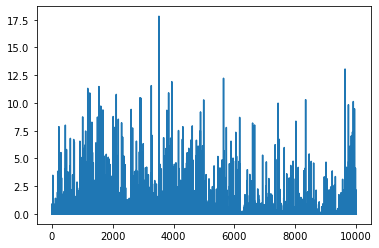

In [298]:
plot(ret)

In [299]:
np.argmax(ret)

3520

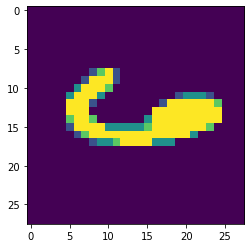

In [301]:
imshow(X_test[3520])

In [326]:
sorted(list(zip(ret, range(ret.shape[0]))), reverse=True)

[(17.81252, 3520),
 (13.056777, 9634),
 (12.2248125, 5642),
 (11.922016, 3941),
 (11.561672, 3269),
 (11.477087, 1549),
 (11.314484, 1181),
 (10.910236, 3838),
 (10.899315, 1247),
 (10.768765, 2118),
 (10.465774, 2896),
 (10.435621, 2927),
 (10.2965975, 8339),
 (10.273332, 4990),
 (10.1275425, 9905),
 (9.977925, 7434),
 (9.840491, 9745),
 (9.715915, 1609),
 (9.47281, 9944),
 (9.416548, 2607),
 (9.368568, 1681),
 (9.339455, 3780),
 (9.190311, 4886),
 (8.773959, 2016),
 (8.741696, 1014),
 (8.725416, 1500),
 (8.700131, 6172),
 (8.583238, 7432),
 (8.5353565, 2185),
 (8.355919, 8020),
 (8.263233, 1319),
 (8.219682, 1260),
 (8.21518, 2293),
 (8.1881485, 6597),
 (8.01215, 6662),
 (7.997717, 445),
 (7.93104, 4615),
 (7.8633018, 233),
 (7.858938, 4306),
 (7.7969646, 2053),
 (7.7885256, 5734),
 (7.745574, 2654),
 (7.516544, 4163),
 (7.497508, 4880),
 (7.48293, 1530),
 (7.466299, 1112),
 (7.3911586, 3808),
 (7.384773, 9879),
 (7.35535, 6045),
 (7.100136, 3284),
 (7.0245843, 9839),
 (6.9914236, 43

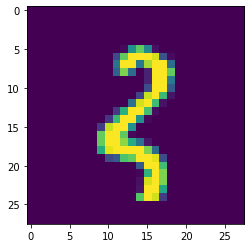

In [327]:
imshow(X_test[4990])

(16, 28, 28)

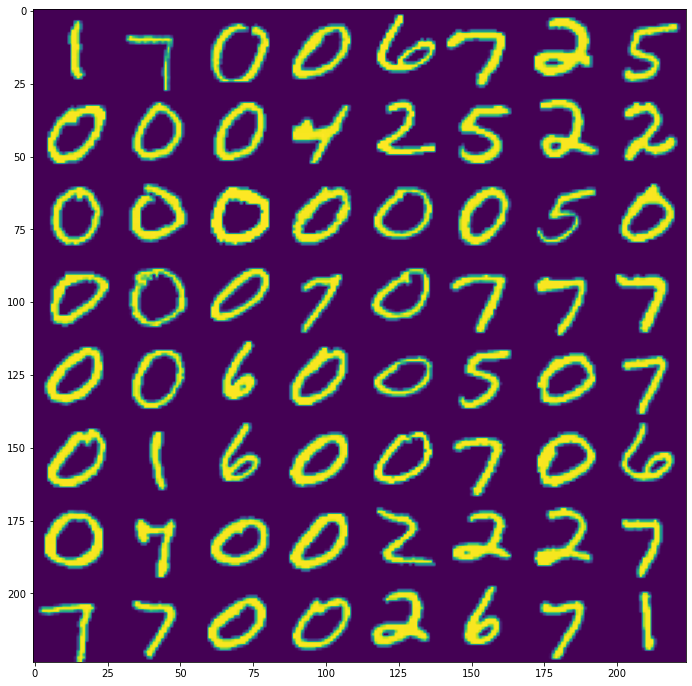

In [351]:
G = 8
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=False)[100:G*G+100]
X_bad = X_test[[x[1] for x in grid]]
X_bad.shape
figsize(12,12)
imshow(np.concatenate(X_bad.reshape((G,28*G,28)),axis=1))